In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver13.csv")
df2 = pd.read_csv("data/26년FA_야수_ver2.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_30620\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


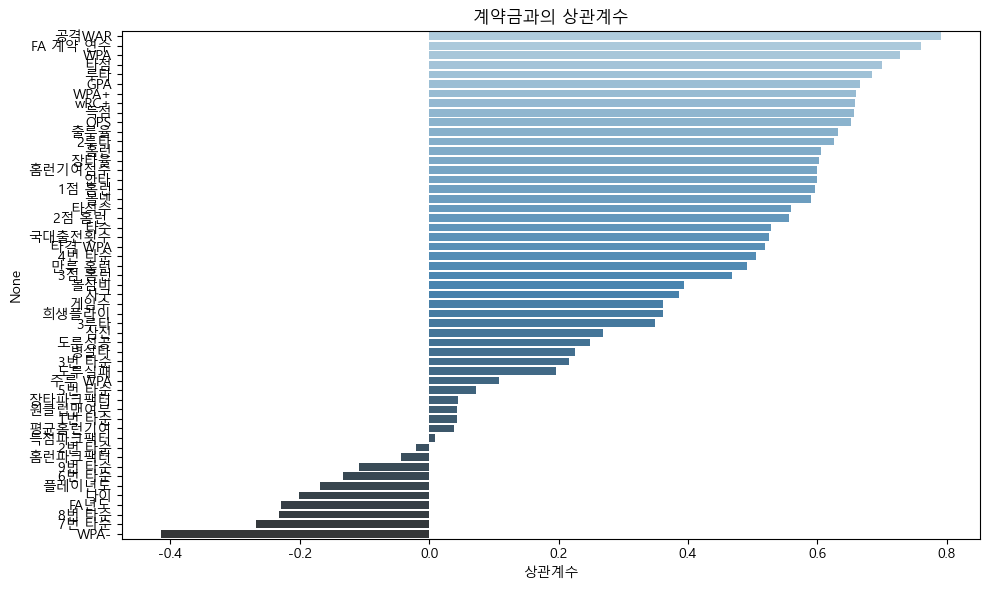

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝 (XGBoost)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 14:23:06,058] A new study created in memory with name: no-name-5c3d98ed-41ef-4666-97f3-3431ce988eb9
[I 2025-08-06 14:23:06,706] Trial 0 finished with value: 116910.46210799683 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.13088430109175908, 'subsample': 0.7340305407103407, 'colsample_bytree': 0.7028571190768544, 'gamma': 3.688640205578128, 'min_child_weight': 4, 'reg_alpha': 3.8932085525951003, 'reg_lambda': 1.5346736388526798}. Best is trial 0 with value: 116910.46210799683.
[I 2025-08-06 14:23:07,472] Trial 1 finished with value: 124726.35573363653 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.29666866847001994, 'subsample': 0.9918624122804023, 'colsample_bytree': 0.8757537237524287, 'gamma': 2.802507636377306, 'min_child_weight': 8, 'reg_alpha': 3.6170891819574553, 'reg_lambda': 0.42192787322093805}. Best is trial 0 with value: 116910.46210799683.
[I 2025-08-06 14:23:08,130] Trial 2 finished with value: 108724.25318

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

print("[XGBoost + Optuna] 최적 파라미터:")
print(best_params)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred) 
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

[XGBoost + Optuna] 최적 파라미터:
{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.012087833272147392, 'subsample': 0.8449269997979783, 'colsample_bytree': 0.8454533977842873, 'gamma': 0.6830446116871338, 'min_child_weight': 2, 'reg_alpha': 1.3237857538262816, 'reg_lambda': 4.5519288179611825}
[모델 평가 지표]
 MSE : 31,935,741,794.70
 RMSE: 178,705.74
 MAE : 102,300.29
 R²  : 0.3753


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

C:\Users\Lee\AppData\Local\Temp\ipykernel_30620\2933799307.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (XGBoost)', palette='YlGnBu')


피처 중요도 (XGBoost + Optuna):
       컬럼명  중요도 (XGBoost)  상관계수 기반 가중치
0    공격WAR       0.153816     0.037415
20  타격 WPA       0.095030     0.024543
19  국대출전횟수       0.082603     0.024811
7       득점       0.061027     0.031086
9      출루율       0.055946     0.029911
1      WPA       0.044080     0.034405
6     wRC+       0.038614     0.031113
15   1점 홈런       0.038074     0.028206
8      OPS       0.035854     0.030850
10     2루타       0.027223     0.029629
12     장타율       0.025921     0.028517
30    도루성공       0.024694     0.011745
14      안타       0.024676     0.028334
45      나이       0.019054     0.009510
25      사구       0.017873     0.018232
5     WPA+       0.017094     0.031188
3       루타       0.017050     0.032392
2       타점       0.016548     0.033115
40   2번 타순       0.015251     0.000941
24     볼삼비       0.013070     0.018640
4      GPA       0.011204     0.031468
27   희생플라이       0.011076     0.017067
23   3점 홈런       0.010823     0.022117
34  주루 WPA       0.010428     0.00510

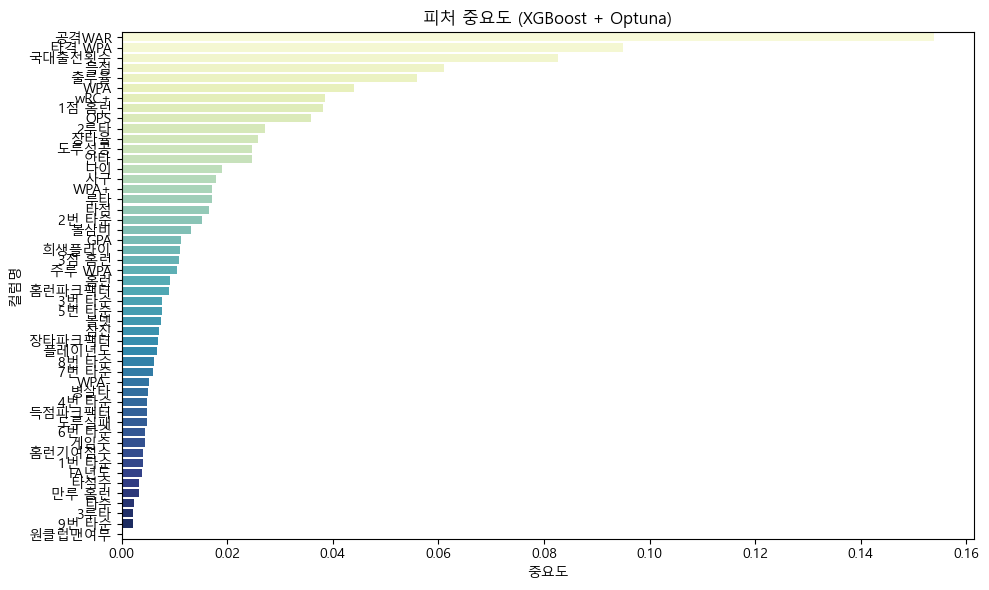

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (XGBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (XGBoost)', ascending=False)

print("피처 중요도 (XGBoost + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (XGBoost)', palette='YlGnBu')
plt.title('피처 중요도 (XGBoost + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (XGBoost + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (XGBoost + Optuna):
    선수명     계약금
0   강민호  217495
1   강백호  114509
2   김재환  181870
3   박병호  176475
4   박승욱   48312
5   박찬호  159495
6   박해민  187149
7   손아섭  152589
8   이재원   97081
9   장성우  151094
10   정훈   45773
11  조수행   52893
12  최원준  121076
13  최형우  191923
14  황재균  121051
